# Startup

## Imports

In [3]:
from metrics import amape_score

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf

## Definitions

In [7]:
def get_poly_first_coef(degree, width, height):
    if degree % 2:
        return 2**degree * height / (width**degree) / 2
    else:
        return 2**degree * height / (width**degree)

## Polynomial data

## Generate polynomial data

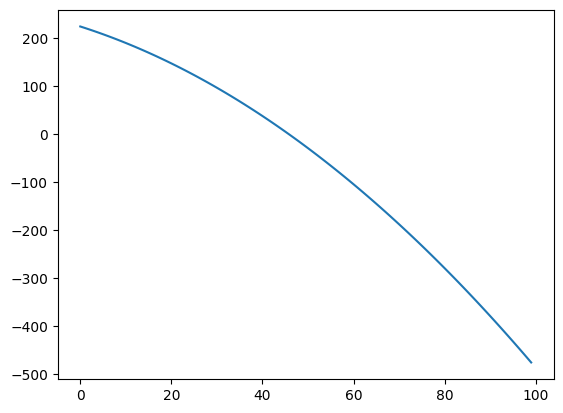

In [89]:
X = np.linspace(-10, 10, 100)
# y = X**4 + (1.5*X+2)**3 -55*(X+3)**2 + 50*(X+1)
# y = X**4 - 5*X**3 - 10*X**2 + 51*X
y = -(X + 5)**2 - X * 25
plt.plot(y)
X_train, X_test, y_train, y_test = train_test_split(X[..., None], y, shuffle=False)

In [ ]:
1/0

In [28]:
def get_parabola_coefs(height, width):
    """Calculates the coefficients for the parabola that can be inscribed inside of a rectangle of given height and width, so that it intersects two upper corners of the rectangle."""
    # The parabola is of the form y = ax^2 + bx + c
    # Since the parabola intersects the two upper corners of the rectangle, we have two equations:
    # height = a * (width/2)^2 + b * (width/2) + c
    # height = a * (-width/2)^2 + b * (-width/2) + c
    # Solving these equations, we get:
    a = 4 * height / width**2
    b = 0
    c = 0
    return a, b, c

In [29]:
a, b, c = get_parabola_coefs(4, 366)

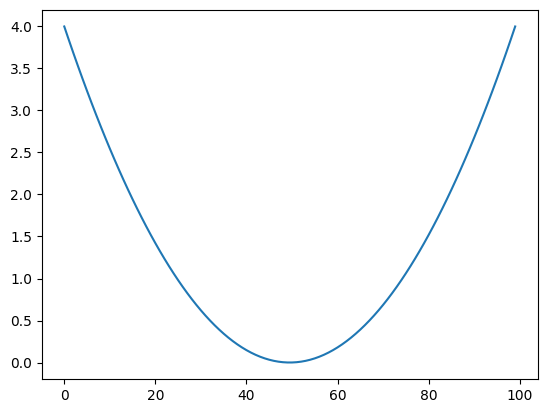

In [30]:
X = np.linspace(-366//2, 366//2, 100)
y = a*X**2 + b*X + c
plt.plot(y)

In [56]:
get_parabola_coefs(4, 366)

(0.00011944220490310251, 0, 0)

In [72]:
get_poly_first_coef(degree=2, width=366, height=4)

0.00011944220490310251

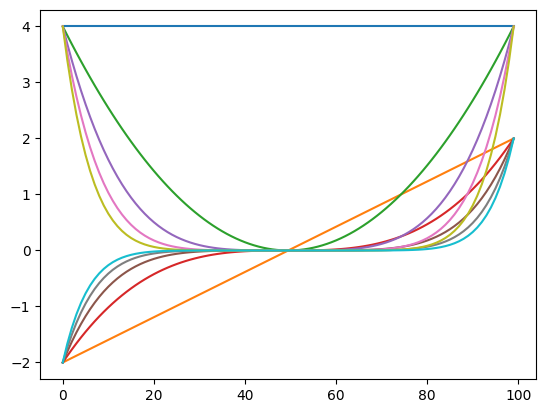

In [71]:
for degree in range(10):
    X = np.linspace(-366//2, 366//2, 100)
    first_coef = get_poly_first_coef(degree=degree, width=366, height=4)
    y = first_coef * X**degree
    plt.plot(y)

In [ ]:
1/0

## Test models

### Neural Regressor

In [24]:
def build_neural_regressor_V4(x, y, max_power):
    init_value = 1
    width = max(x)-min(x)
    height = max(y)-min(y)
    input_layer = tf.keras.layers.Input(shape=(1), name='input')
    entrance_layers = {}
    power_layers = {}
    # previous_layer = input_layer
    for i in range(max_power+1):
        previous_entrance_layer = input_layer
        entrance_layers[i] = {}
        for j in range(i+1):
            entrance_layers[i][j] = tf.keras.layers.Dense(
                1,
                name=f'entrance_{i}{j}',
                kernel_initializer=tf.keras.initializers.Constant(init_value),
                use_bias=True,
                bias_initializer=tf.keras.initializers.Constant(init_value)
            )(previous_entrance_layer)
            previous_entrance_layer = entrance_layers[i][j]
        first_coef = get_poly_first_coef(
            degree=i,
            width=width,
            height=height
        )
        constraint = tf.keras.constraints.MinMaxNorm(
                min_value=-first_coef, max_value=first_coef, rate=1.0, axis=0
            )
        power_layers[i] = tf.keras.layers.Dense(
            1,
            name=f'power_{i}',
            kernel_initializer=tf.keras.initializers.Constant(init_value),
            kernel_constraint = constraint,
            activation=lambda x: x**i,
            use_bias=True,
            bias_initializer=tf.keras.initializers.Constant(init_value)
        )(entrance_layers[i][j])
    concat_layer = tf.keras.layers.Concatenate(name='concat')(list(power_layers.values()))
    # exit_layer = tf.keras.layers.Dense(
    #     max_power+1,
    #     name='exit',
    #     kernel_initializer=tf.keras.initializers.Constant(1),
    #     use_bias=False,
    #     # bias_initializer=tf.keras.initializers.Constant(1)
    # )(concat_layer)
    output_layer = tf.keras.layers.Dense(
        1,
        name='output',
        kernel_initializer=tf.keras.initializers.Constant(1),
        use_bias=False,
        # bias_initializer=tf.keras.initializers.Constant(1)
    )(concat_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [77]:
def build_neural_regressor_V5(x, y, max_power):
    init_value = 1
    width = max(x)-min(x)
    height = max(y)-min(y)
    input_layer = tf.keras.layers.Input(shape=(1), name='input')
    entrance_layers = {}
    power_layers = {}
    first_coefs = {}
    for i in range(max_power+1):
        first_coefs[i] = get_poly_first_coef(
            degree=i,
            width=width,
            height=height
        )
        constraint = tf.keras.constraints.MinMaxNorm(
            min_value=-first_coefs[i],
            max_value=first_coefs[i],
            rate=1.0,
            axis=0
        )
        previous_entrance_layer = input_layer
        entrance_layers[i] = {}
        for j in range(i+1):
            entrance_layers[i][j] = tf.keras.layers.Dense(
                1,
                name=f'entrance_{i}{j}'
            )(previous_entrance_layer)
            previous_entrance_layer = entrance_layers[i][j]
        power_layers[i] = tf.keras.layers.Dense(
            1,
            name=f'power_{i}',
            kernel_constraint = constraint,
            activation=lambda x: x**i
        )(entrance_layers[i][j])
    concat_layer = tf.keras.layers.Concatenate(name='concat')(list(power_layers.values()))
    exit_layer = tf.keras.layers.Dense(
        max_power+1,
        name='exit',
        use_bias=False
    )(concat_layer)
    output_layer = tf.keras.layers.Dense(
        1,
        name='output',
        use_bias=False
    )(exit_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [90]:
def build_neural_regressor_V6(x, y, max_power):
    init_value = 1
    width = max(x) - min(x)
    height = max(y) - min(y)
    input_layer = tf.keras.layers.Input(shape=(1), name='input')
    entrance_layers = {}
    power_layers = {}
    linear_layer = tf.keras.layers.Dense(
            1,
            name='linear'
    )(input_layer)
    for i in range(max_power+1):
        previous_entrance_layer = input_layer
        entrance_layers[i] = {}
        for j in range(i+1):
            entrance_layers[i][j] = tf.keras.layers.Dense(
                1,
                name=f'entrance_{i}{j}',
                kernel_initializer=tf.keras.initializers.Constant(init_value),
                use_bias=True,
                bias_initializer=tf.keras.initializers.Constant(init_value)
            )(previous_entrance_layer)
            previous_entrance_layer = entrance_layers[i][j]
        first_coef = get_poly_first_coef(
            degree=i,
            width=width,
            height=height
        )
        constraint = tf.keras.constraints.MinMaxNorm(
            min_value=-first_coef,
            max_value=first_coef,
            rate=1.0,
            axis=0
        )
        power_layers[i] = tf.keras.layers.Dense(
            1,
            name=f'power_{i}',
            kernel_constraint = constraint,
            activation=lambda x: x**i,
            use_bias=True
        )(entrance_layers[i][j])
    powers_concat_layer = tf.keras.layers.Concatenate(name='powers_concat')(list(power_layers.values()))
    powers_output_layer = tf.keras.layers.Dense(
        1,
        name='powers_output',
        kernel_initializer=tf.keras.initializers.Constant(1),
        use_bias=False
    )(powers_concat_layer)
    concat_layer = tf.keras.layers.Concatenate(name='concat')([powers_output_layer, linear_layer])
    output_layer = tf.keras.layers.Dense(
        1,
        name='output',
        kernel_initializer=tf.keras.initializers.Constant(1),
        use_bias=False
    )(concat_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

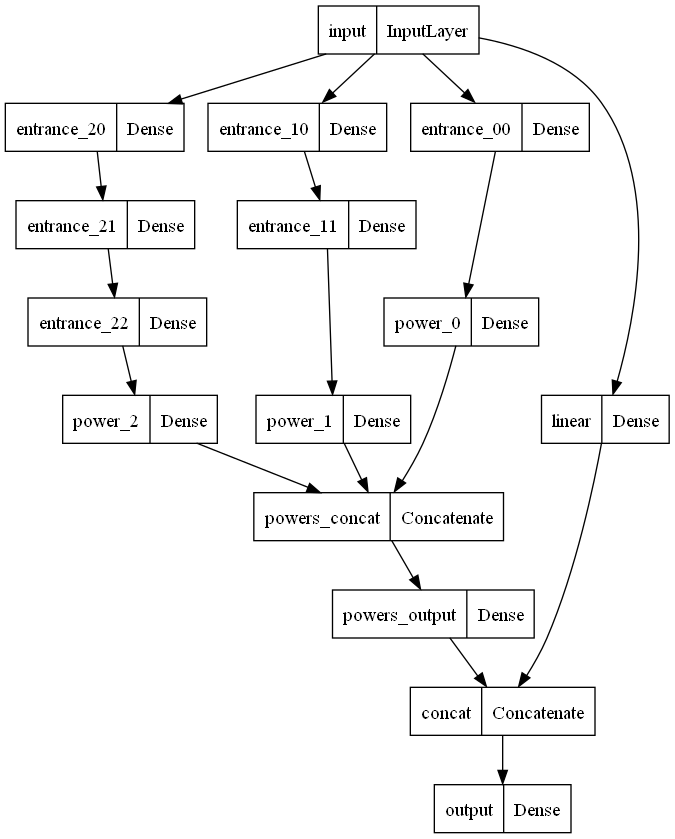

In [91]:
model = build_neural_regressor_V6(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

1/1 [==============================] - 0s 28ms/step


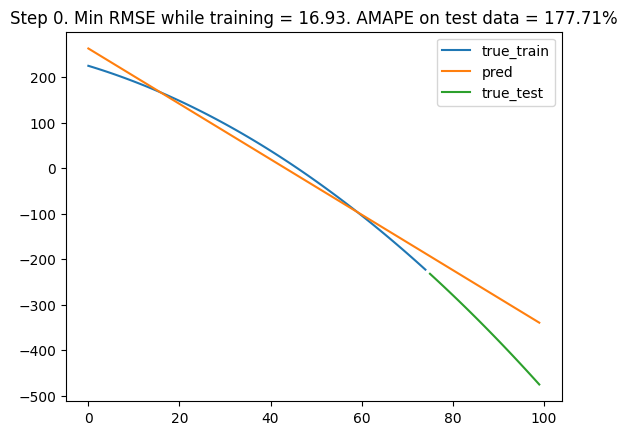

1/1 [==============================] - 0s 29ms/step


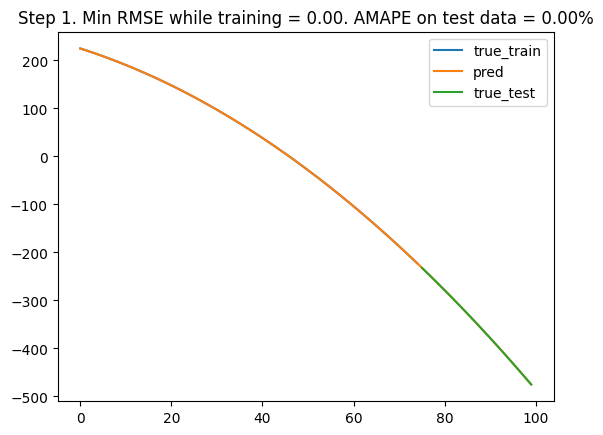

In [92]:
adam = tf.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=1000, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    # plt.show()
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()
    if amape < 0.1:
        break

In [ ]:
1/0

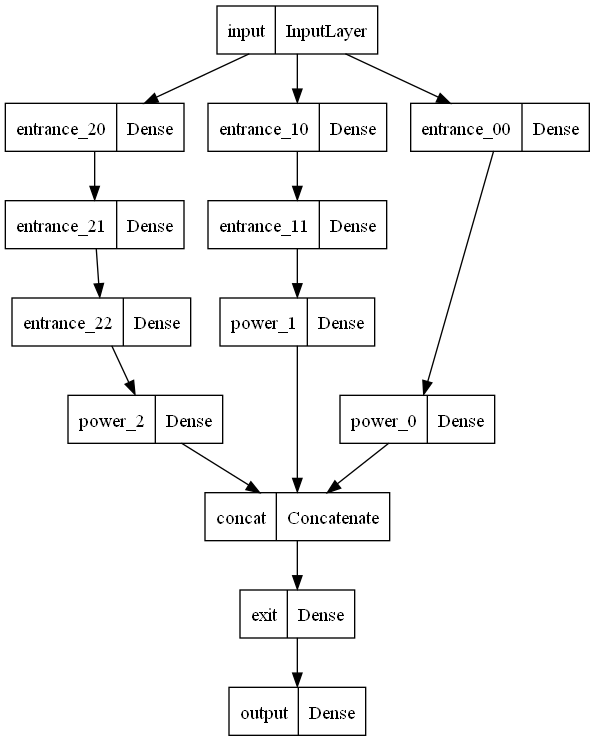

In [80]:
model = build_neural_regressor_V5(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

1/1 [==============================] - 0s 36ms/step


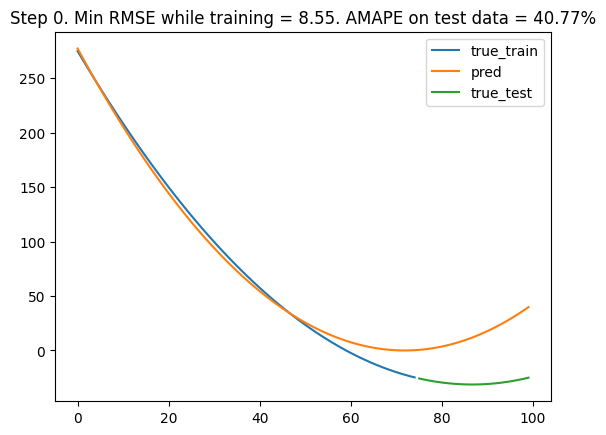

1/1 [==============================] - 0s 29ms/step


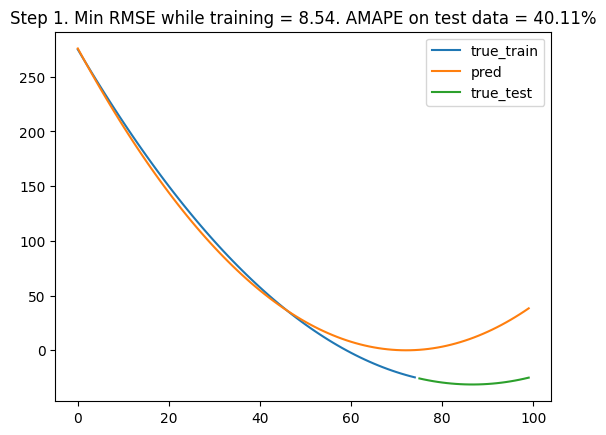

1/1 [==============================] - 0s 35ms/step


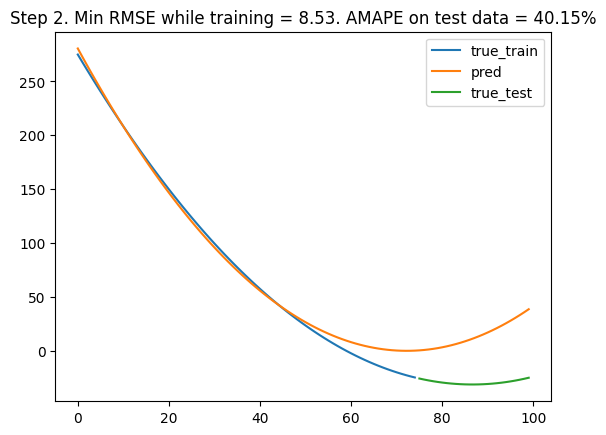

1/1 [==============================] - 0s 31ms/step


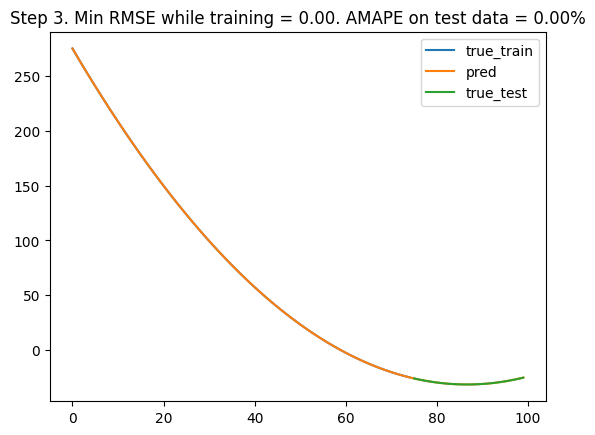

In [58]:
adam = tf.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=1000, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    # plt.show()
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()
    if amape < 0.1:
        break

In [ ]:
1/0

In [ ]:
model = build_neural_regressor_V4(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

1/1 [==============================] - 0s 30ms/step


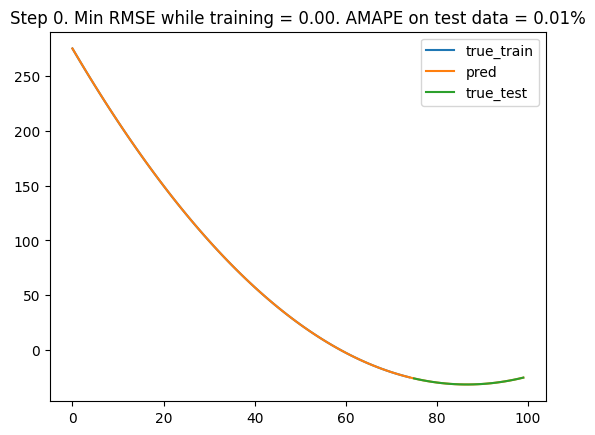

1/1 [==============================] - 0s 34ms/step


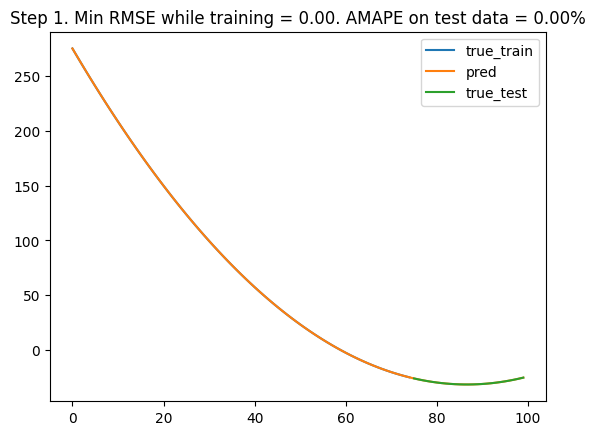

1/1 [==============================] - 0s 34ms/step


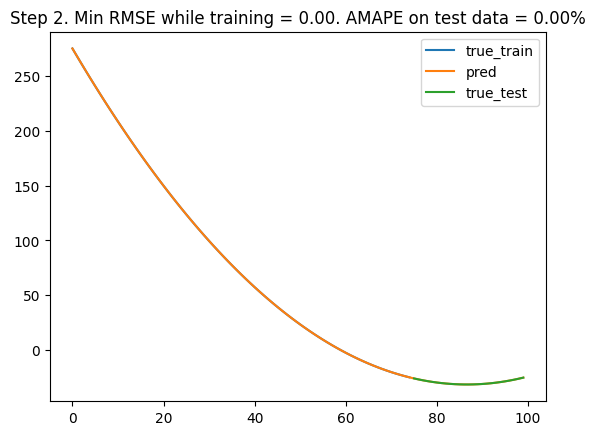

1/1 [==============================] - 0s 53ms/step


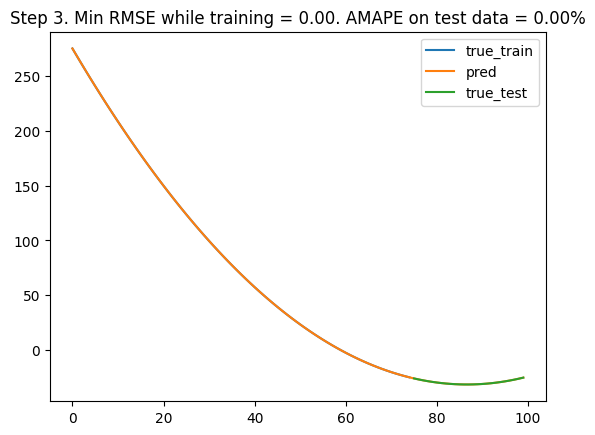

1/1 [==============================] - 0s 29ms/step


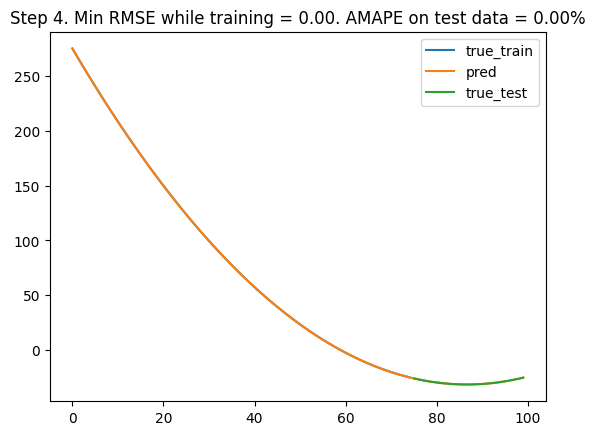

1/1 [==============================] - 0s 28ms/step


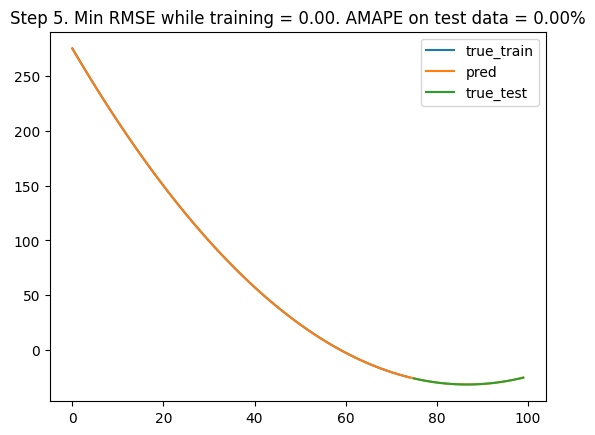

1/1 [==============================] - 0s 30ms/step


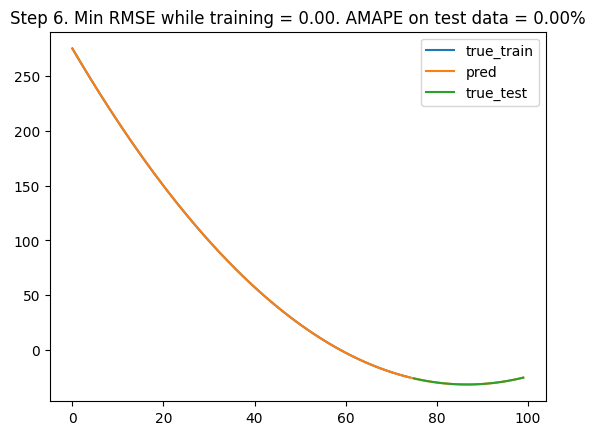

1/1 [==============================] - 0s 27ms/step


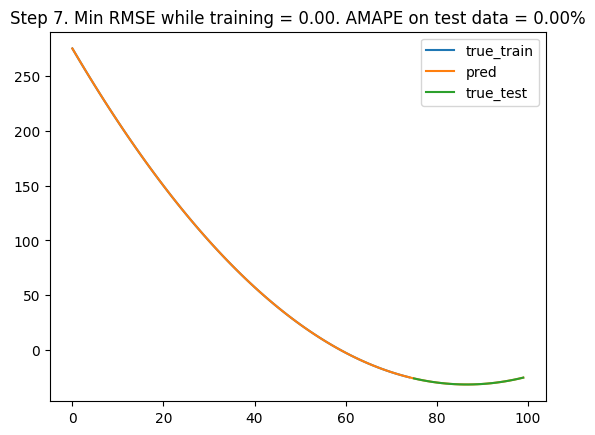

1/1 [==============================] - 0s 27ms/step


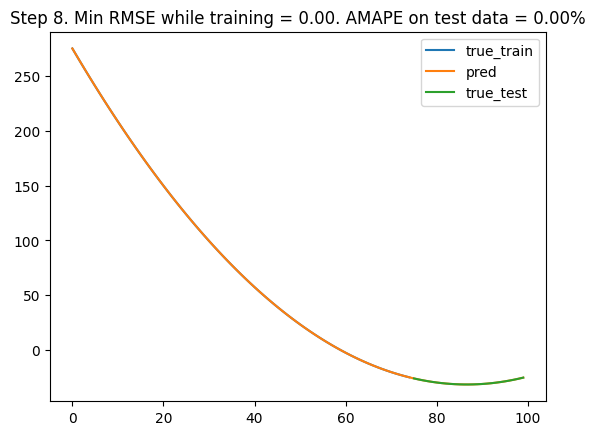

1/1 [==============================] - 0s 28ms/step


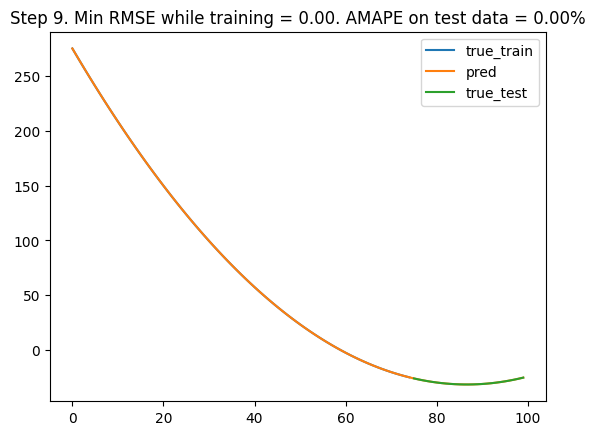

In [84]:
adam = tf.optimizers.Adam(learning_rate=0.25)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=1000, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()

### XGBoost

In [71]:
from xgboost import XGBRegressor

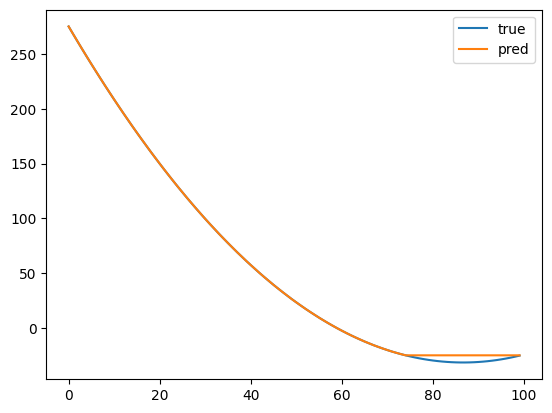

In [96]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plt.plot(y, label='true')
plt.plot(xgb.predict(X[..., None]), label='pred')
plt.legend()
plt.show()

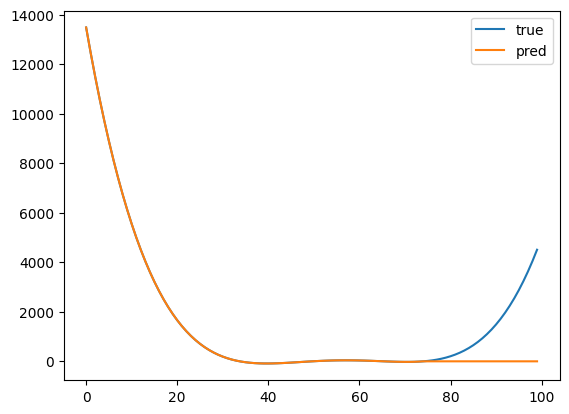

In [99]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plt.plot(y, label='true')
plt.plot(xgb.predict(X[..., None]), label='pred')
plt.legend()
plt.show()

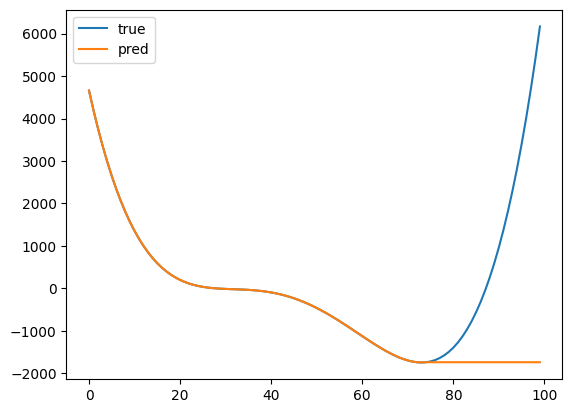

In [102]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

plt.plot(y, label='true')
plt.plot(xgb.predict(X[..., None]), label='pred')
plt.legend()
plt.show()

### SVR

In [67]:
from sklearn.svm import SVR

In [59]:
SVR_DEGREE = 2
svr = SVR(kernel='poly', C=100, gamma='auto', degree=SVR_DEGREE, epsilon=0.1, coef0=1)

In [60]:
svr.fit(X_train, y_train)

SVR(C=100, coef0=1, degree=2, gamma='auto', kernel='poly')

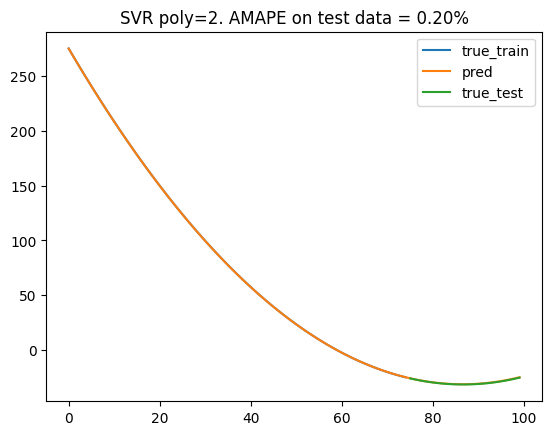

In [61]:
plt.plot(range(len(X_train)), y_train, label='true_train')
plt.plot(range(len(X)), svr.predict(X[..., None]).flatten(), label='pred')
plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
amape = amape_score(y_test, svr.predict(X_test).flatten(), reference=y_train)
plt.title(f'SVR poly={SVR_DEGREE}. AMAPE on test data = {amape:.2f}%')
plt.legend()
plt.show()

# SIN wave

## Generate a SIN wave

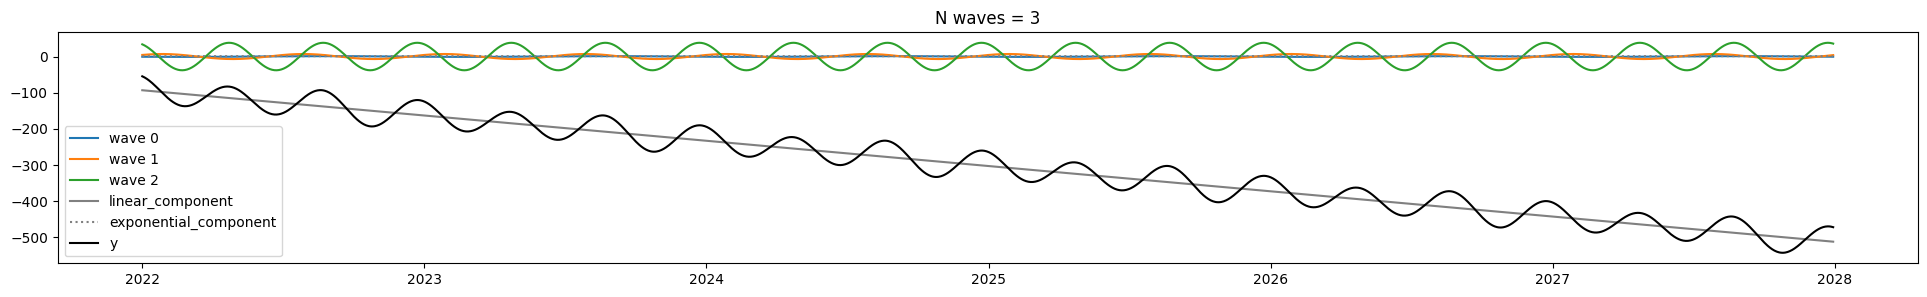

In [100]:
plt.figure(figsize=(24,3))
n_years = np.random.randint(1, 15)
period_starts = pd.Timestamp('2022-01-01')
duration_days = 365 * n_years
period_ends = period_starts + pd.Timedelta(days=duration_days)
x_date = pd.date_range(period_starts, period_ends, freq='D')[:-1]
N = 3
X = np.linspace(1, duration_days, duration_days)
a = np.random.randint(-500, 500) / (n_years * 365.25)

waves = {}
for i in range(N):
    frequency = 2 * np.pi / 365.25 * (i + 1)

    beta = 1
    elevation_power = 0
    amplitude_change_power = 0
    variation = True

    amplitude = np.random.randint(-100, 100)
    phase_shift = np.random.randint(-180, 180)
  
    
    b = np.random.randint(-100, 100)

    if not variation:
        waves[i] = amplitude * np.sin(frequency * X + phase_shift)
    else:
        waves[i] = amplitude * (X**amplitude_change_power) * np.sin(X**beta * frequency + phase_shift)

    plt.plot(x_date, waves[i], label=f'wave {i}')
y = np.sum(list(waves.values()), axis=0)
linear_component = a * X + b
exponential_component = X**elevation_power
y += linear_component
y += exponential_component
plt.plot(x_date, linear_component, color='grey', label='linear_component')
plt.plot(x_date, exponential_component, color='grey', label='exponential_component', linestyle='dotted')
plt.plot(x_date, y, color='black', label='y')
plt.legend()
plt.title(f'N waves = {N}')
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X.reshape(-1,1), y, shuffle=False)

## Test models

### Neural Regressor V6

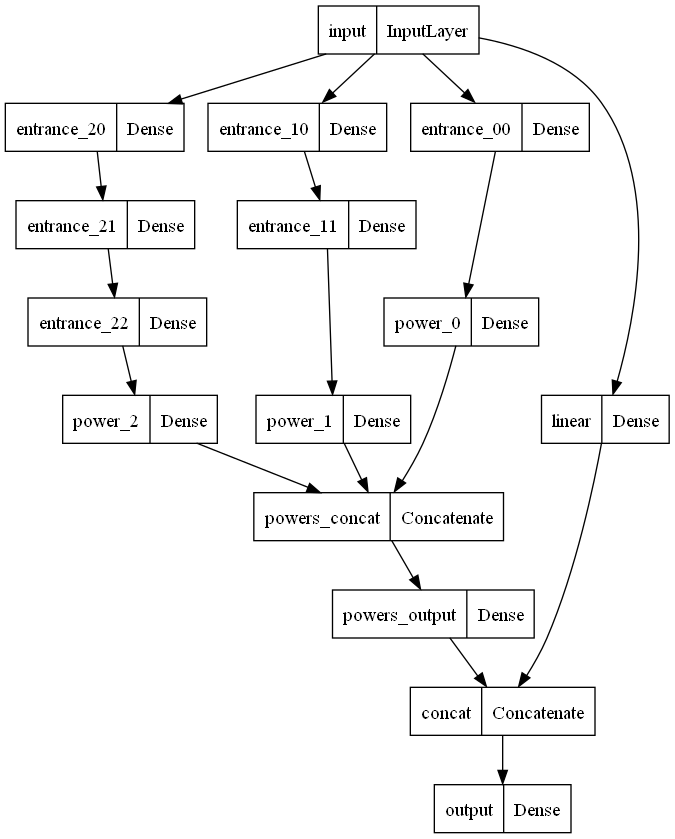

In [101]:
model = build_neural_regressor_V6(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

18/18 [==============================] - 0s 1ms/step


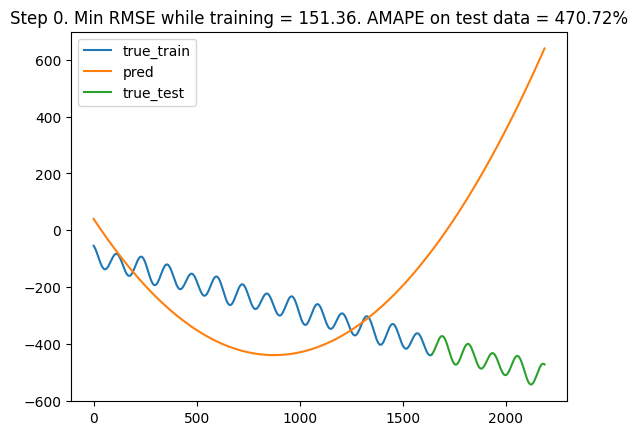

18/18 [==============================] - 0s 1ms/step


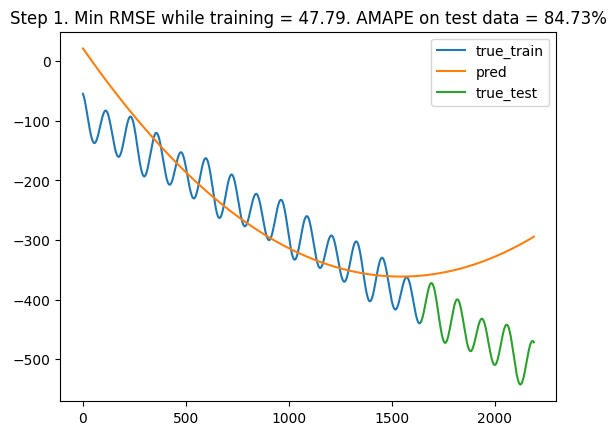

18/18 [==============================] - 0s 1ms/step


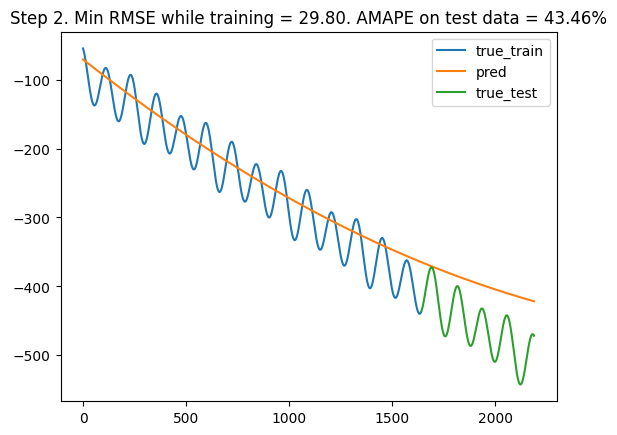

18/18 [==============================] - 0s 1ms/step


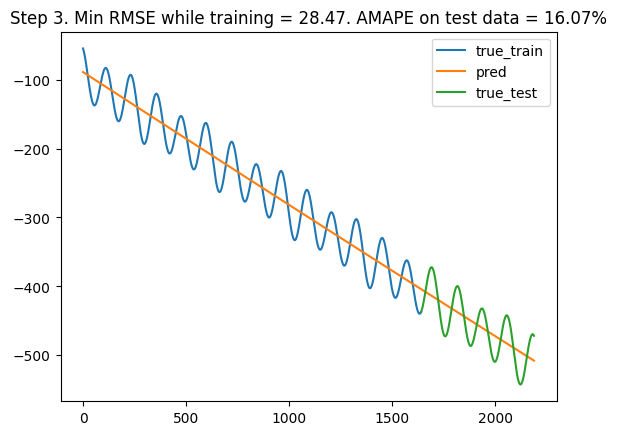

18/18 [==============================] - 0s 1ms/step


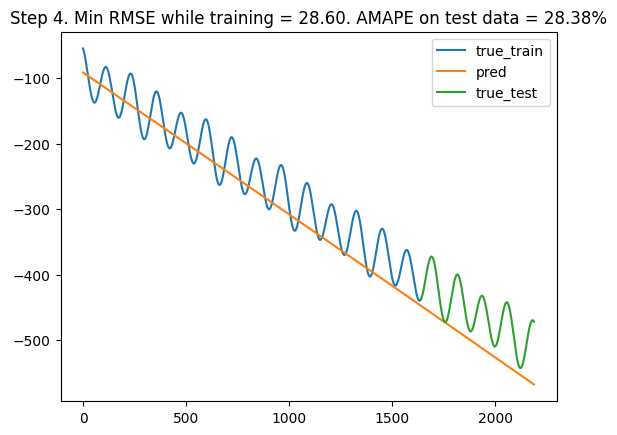

18/18 [==============================] - 0s 1ms/step


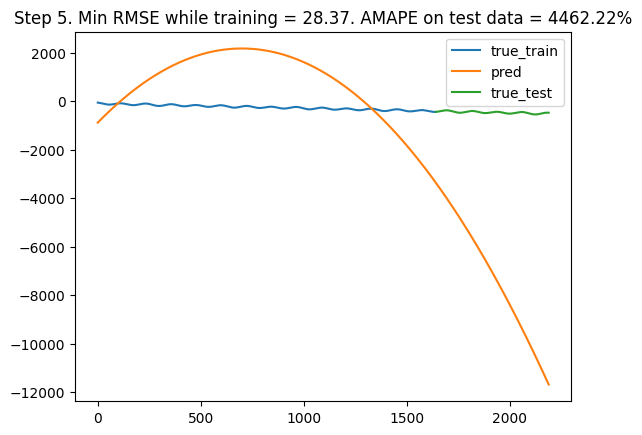

18/18 [==============================] - 0s 1ms/step


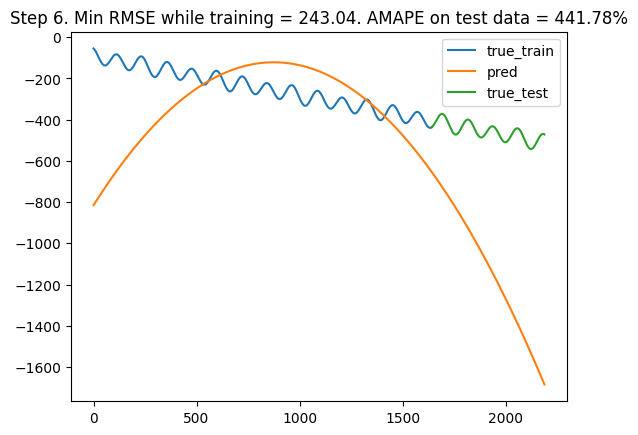

18/18 [==============================] - 0s 1ms/step


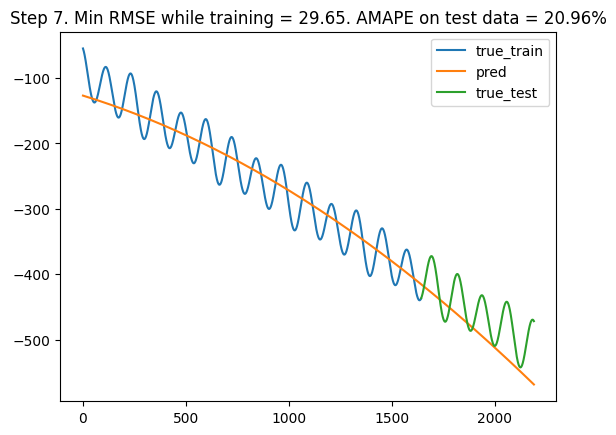

18/18 [==============================] - 0s 1ms/step


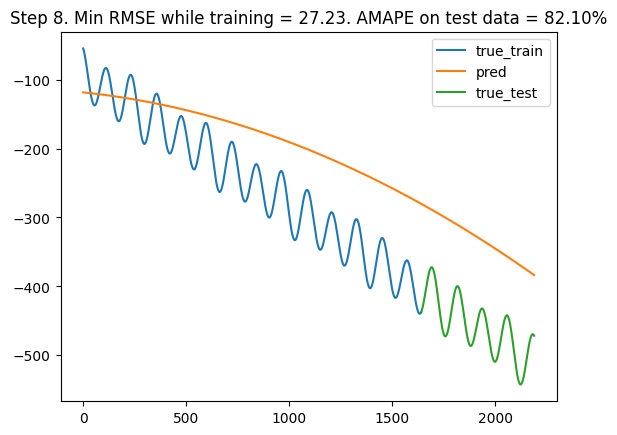

18/18 [==============================] - 0s 1ms/step


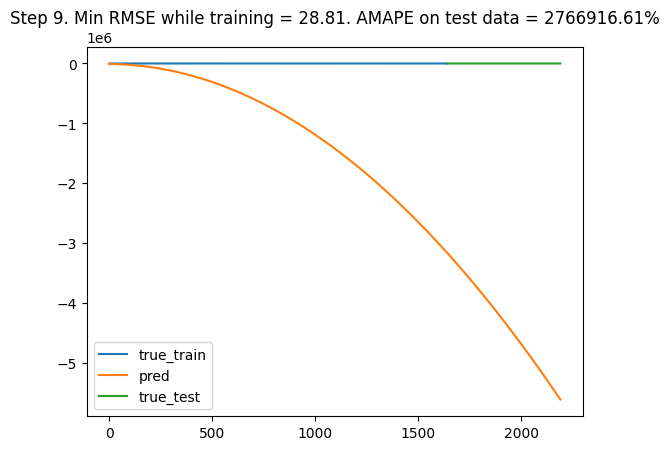

In [102]:
adam = tf.optimizers.Adam(learning_rate=0.25)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=100, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()

### Neural Regressor V5

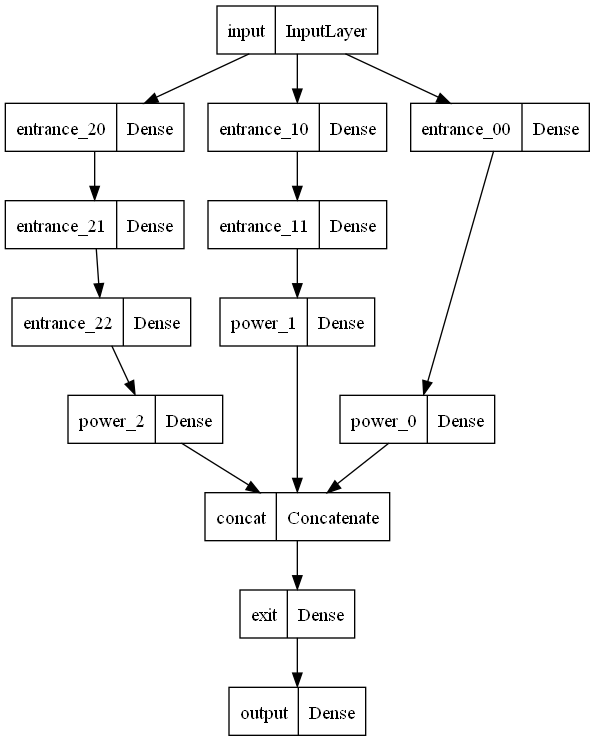

In [103]:
model = build_neural_regressor_V5(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

18/18 [==============================] - 0s 1ms/step


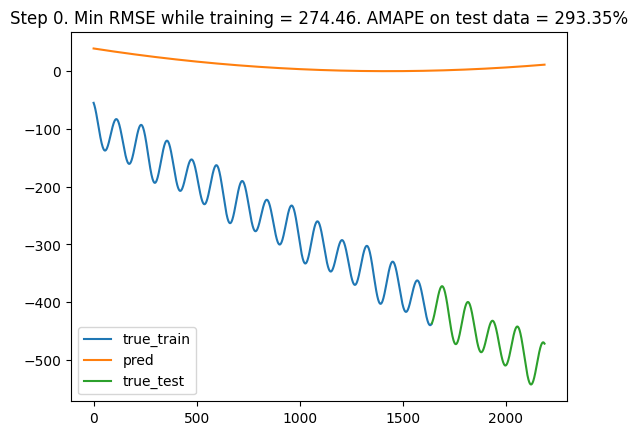

18/18 [==============================] - 0s 1ms/step


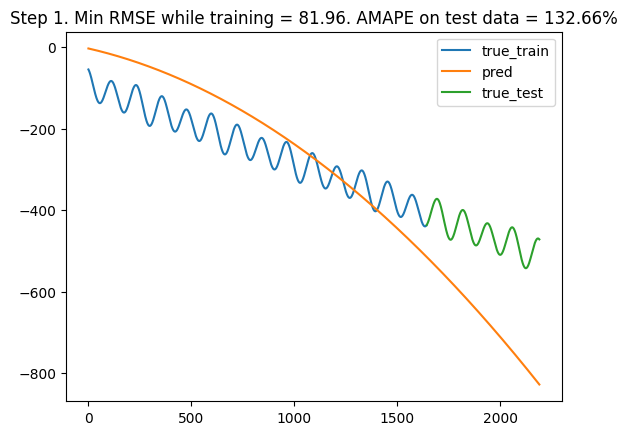

18/18 [==============================] - 0s 1ms/step


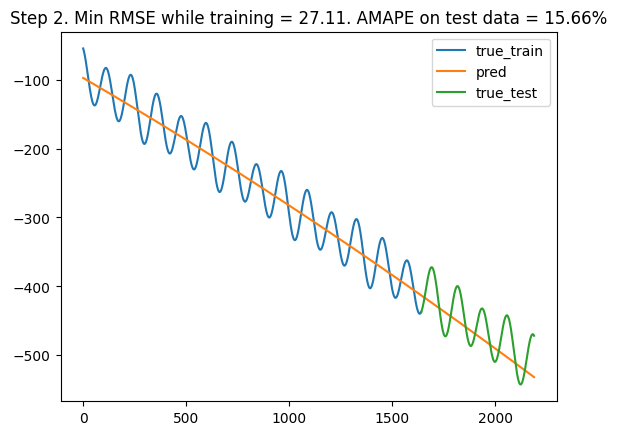

18/18 [==============================] - 0s 1ms/step


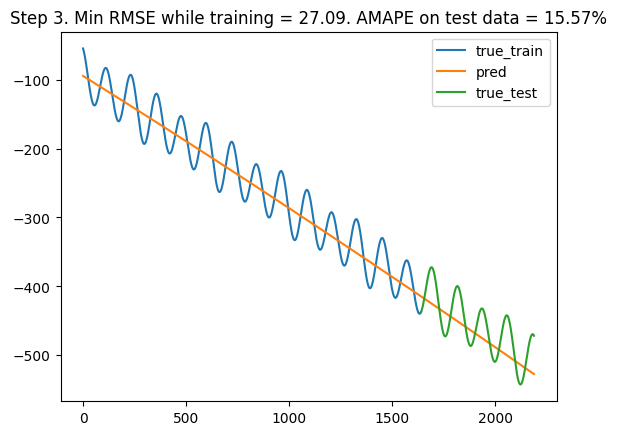

18/18 [==============================] - 0s 1ms/step


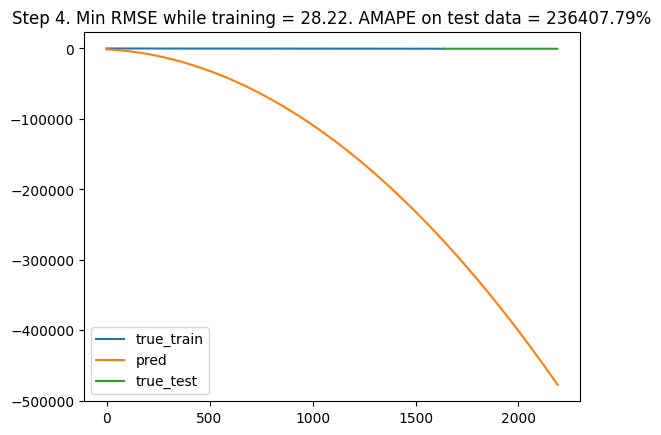

18/18 [==============================] - 0s 1ms/step


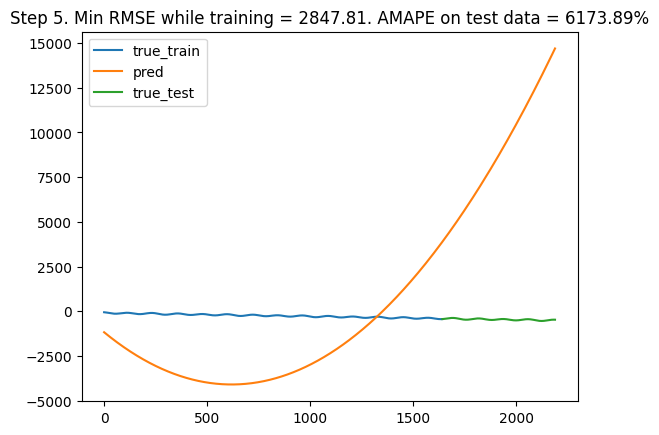

18/18 [==============================] - 0s 1ms/step


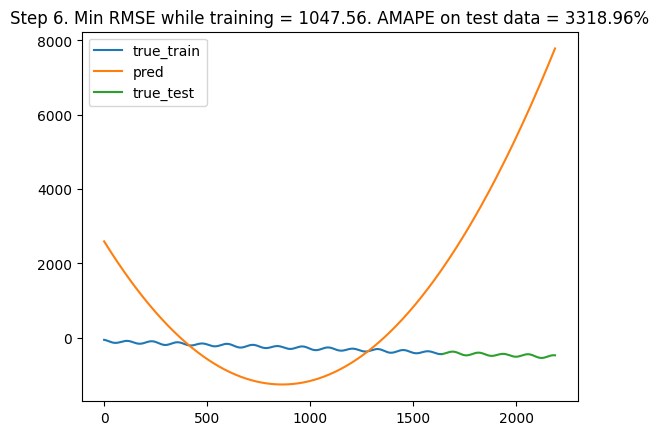

18/18 [==============================] - 0s 1ms/step


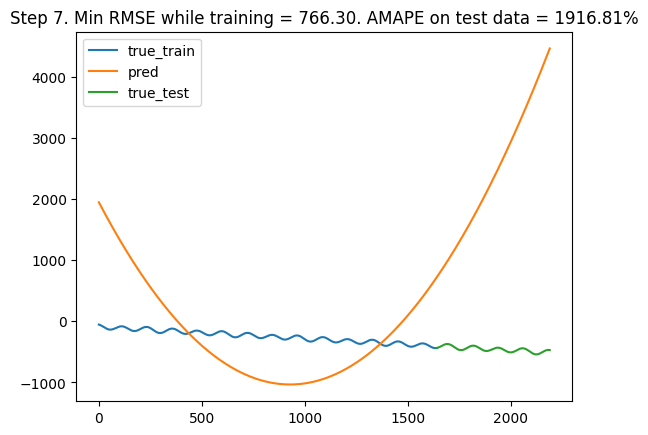

18/18 [==============================] - 0s 1ms/step


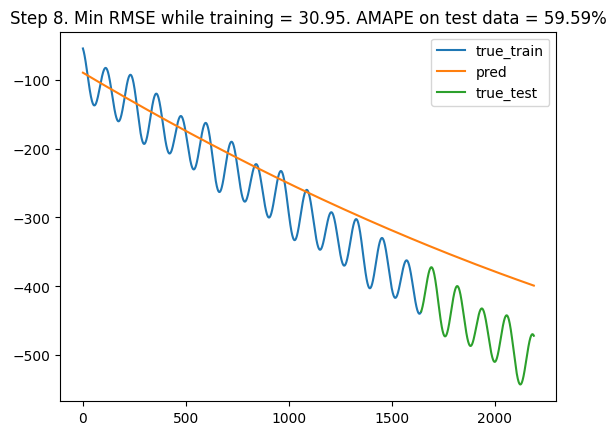

18/18 [==============================] - 0s 1ms/step


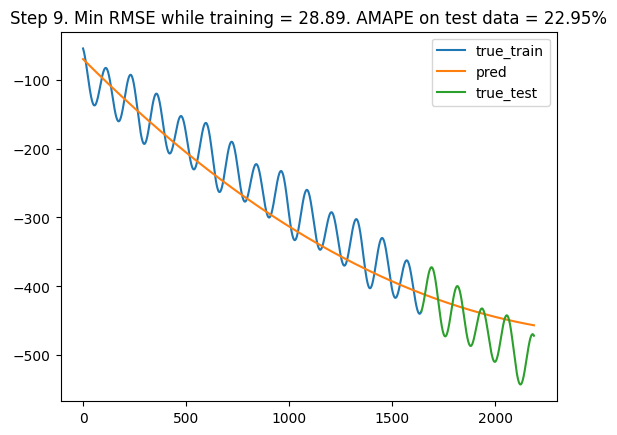

In [104]:
adam = tf.optimizers.Adam(learning_rate=0.25)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=100, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()

### Neural Regressor V4

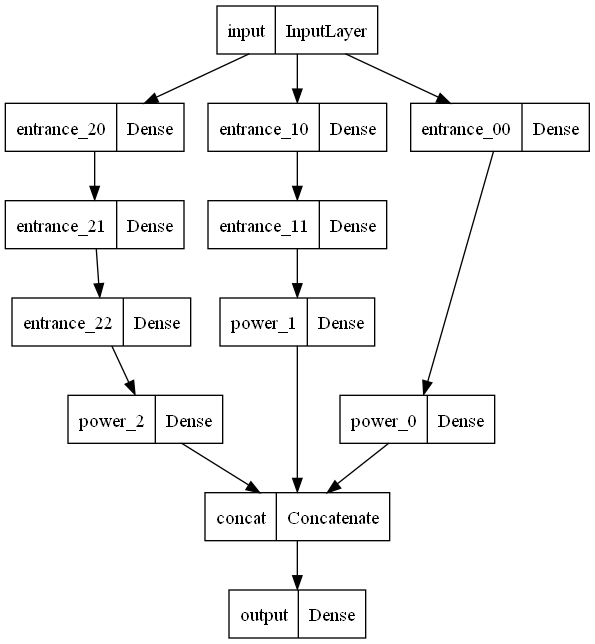

In [106]:
model = build_neural_regressor_V4(X_train, y_train, 2)
tf.keras.utils.plot_model(model)

18/18 [==============================] - 0s 1ms/step


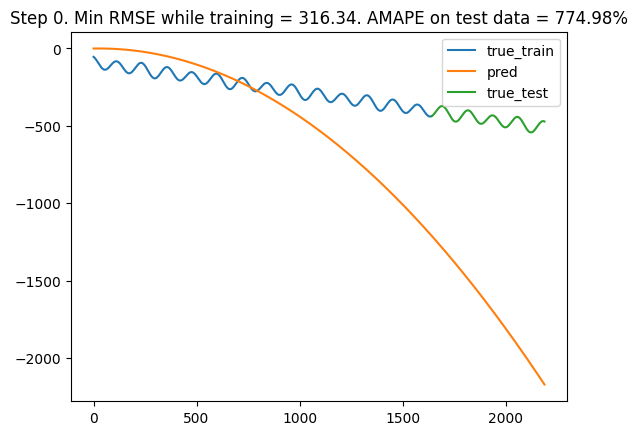

18/18 [==============================] - 0s 1ms/step


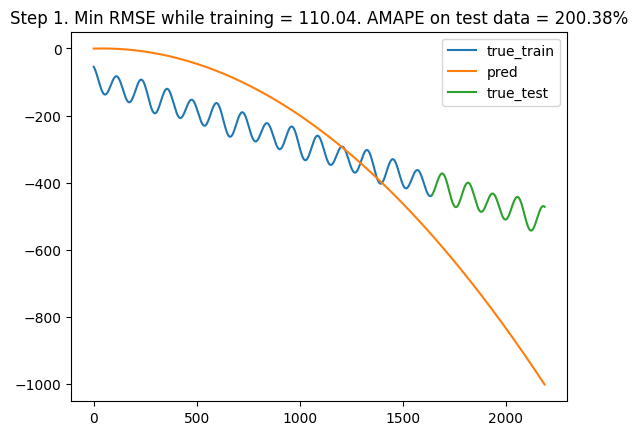

18/18 [==============================] - 0s 1ms/step


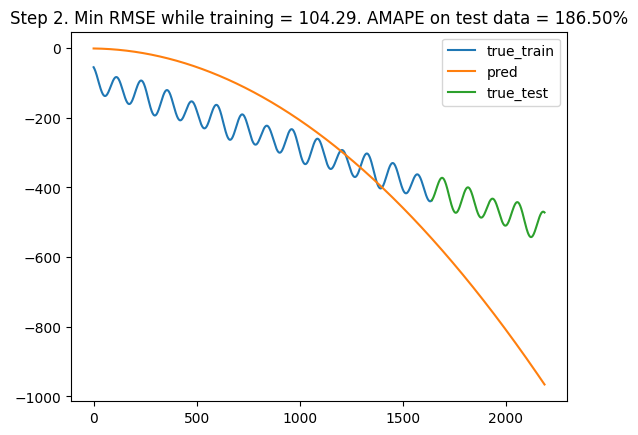

18/18 [==============================] - 0s 1ms/step


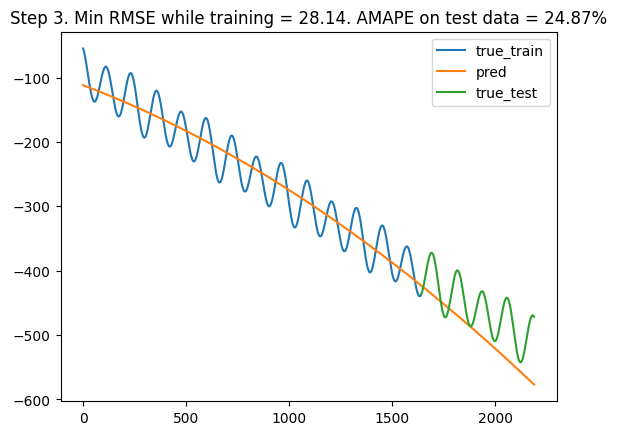

18/18 [==============================] - 0s 1ms/step


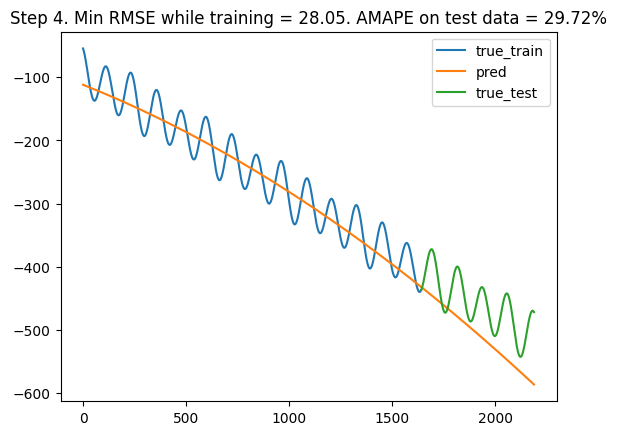

18/18 [==============================] - 0s 1ms/step


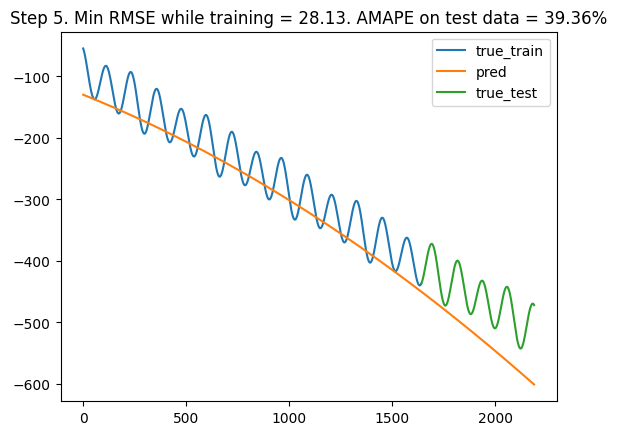

18/18 [==============================] - 0s 1ms/step


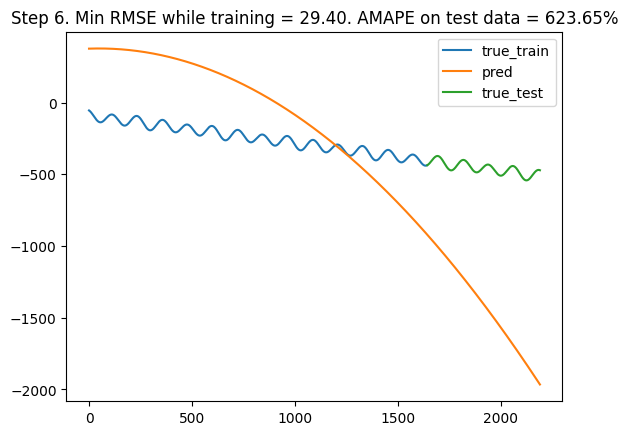

18/18 [==============================] - 0s 1ms/step


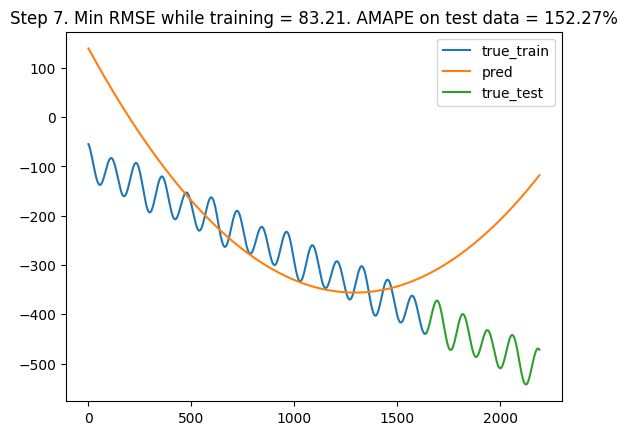

18/18 [==============================] - 0s 1ms/step


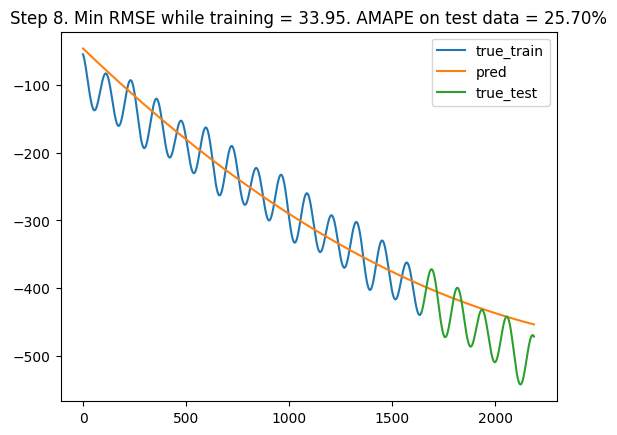

18/18 [==============================] - 0s 1ms/step


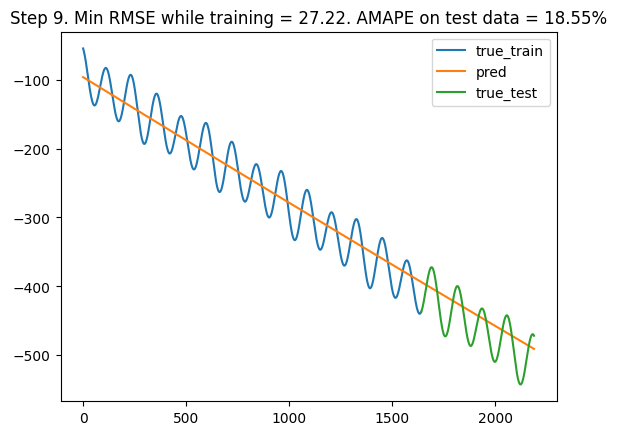

In [107]:
adam = tf.optimizers.Adam(learning_rate=0.25)
model.compile(loss='mse', optimizer=adam)
for step in range(10):
    history = model.fit(X_train, y_train, epochs=100, verbose=False)
    loss = history.history['loss']
    # plt.plot(loss)
    # plt.title(f'MSE = {loss[-1]}')
    plt.plot(range(len(X_train)), y_train, label='true_train')
    plt.plot(range(len(X)), model.predict(X).flatten(), label='pred')
    plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
    amape = amape_score(y_test, model.predict(X_test.flatten()).flatten(), reference=y_train)
    plt.title(f'Step {step}. Min RMSE while training = {min(loss)**0.5:.2f}. AMAPE on test data = {amape:.2f}%')
    plt.legend()
    plt.show()

### SVR

In [68]:
SVR_DEGREE = 2
svr = SVR(kernel='poly', C=100, gamma='auto', degree=SVR_DEGREE, epsilon=0.1, coef0=1, max_iter=10**5)
svr.fit(X_train, y_train)

c:\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVR(C=100, coef0=1, degree=2, gamma='auto', kernel='poly', max_iter=100000)

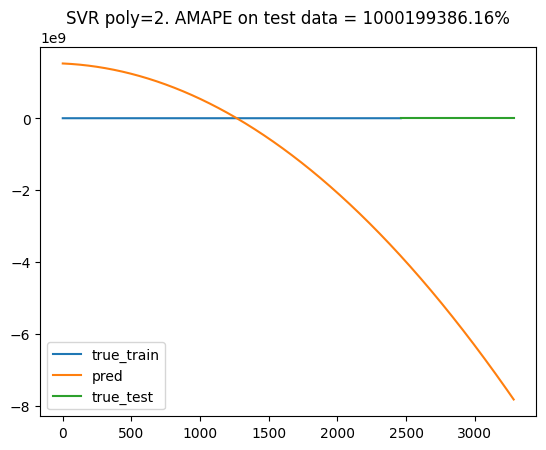

In [69]:
plt.plot(range(len(X_train)), y_train, label='true_train')
plt.plot(range(len(X)), svr.predict(X[..., None]).flatten(), label='pred')
plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
amape = amape_score(y_test, svr.predict(X_test).flatten(), reference=y_train)
plt.title(f'SVR poly={SVR_DEGREE}. AMAPE on test data = {amape:.2f}%')
plt.legend()
plt.show()

### XGBoost

In [108]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

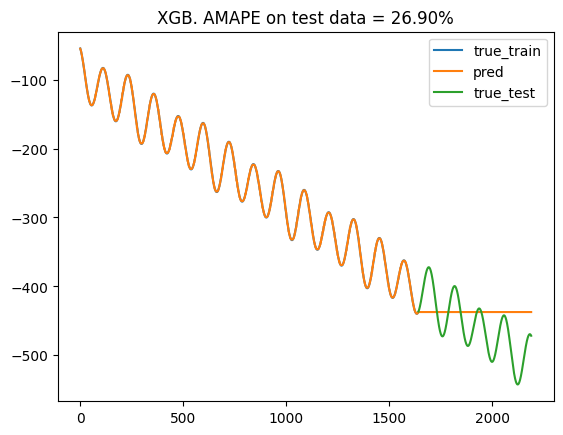

In [109]:
plt.plot(range(len(X_train)), y_train, label='true_train')
plt.plot(range(len(X)), xgb.predict(X[..., None]).flatten(), label='pred')
plt.plot(range(len(X_train), len(X)), y_test, label='true_test')
amape = amape_score(y_test, xgb.predict(X_test).flatten(), reference=y_train)
plt.title(f'XGB. AMAPE on test data = {amape:.2f}%')
plt.legend()
plt.show()